<a href="https://colab.research.google.com/github/Tumars-web/E-commerce-user-growth-analysis/blob/main/notebooks/02_%E7%94%A8%E6%88%B7%E5%A4%8D%E8%B4%AD%E7%8E%87%E4%B8%8E%E7%95%99%E5%AD%98%E7%8E%87%E5%88%86%E6%9E%90(repurchase_retention).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import pandas as pd
import zipfile
import urllib.request
import matplotlib.pyplot as plt
import seaborn as sns


url = 'https://github.com/Tumars-web/E-commerce-user-growth-analysis/raw/main/cleaned_data.csv.zip'
zip_path = 'cleaned_data.zip'

# 下载压缩包
urllib.request.urlretrieve(url, zip_path)

# 解压缩
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()

# 读取 CSV
df = pd.read_csv('cleaned_data.csv')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

print("数据加载成功！")
df.head()


数据加载成功！


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [4]:
#分析目标：判断用户是否购买过2次以上，计算总体复购率
#用户复购率（Repeat_rate)/留存率(Cohort analysis)/留存曲线（Retention_curve)

#按客户统计购买次数
purchase_counts = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
purchase_counts.columns = ['CustomerID', 'PurchaseTimes']

#判断是否为复购用户（购买超过一次）
purchase_counts['IsRepeatBuyer'] = purchase_counts['PurchaseTimes'].apply(lambda x: 1 if x > 1 else 0)

#计算复购率
total_users = purchase_counts.shape[0]
repeat_users = purchase_counts['IsRepeatBuyer'].sum()
repeat_rate = repeat_users / total_users

print(f"用户复购率为：{repeat_rate:.2%}（复购用户数：{repeat_users} / 总用户数：{total_users}）")


用户复购率为：65.58%（复购用户数：2845 / 总用户数：4338）


In [11]:
#留存分析：基于Cohort 计算每月的用户回访情况
# 添加用户首次下单的月份作为 Cohort（种子月份）
df['CohortMonth'] = df.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M').astype(str)
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M').astype(str)

# 创建 Cohort 表格
cohort_data = df.groupby(['CohortMonth', 'InvoiceMonth'])['CustomerID'].nunique().reset_index()

# 添加月份间隔（几个月之后）
from pandas.api.types import CategoricalDtype

def get_month_diff(start, end):
    start = pd.Period(start, freq='M')
    end = pd.Period(end, freq='M')
    return (end.year - start.year) * 12 + (end.month - start.month)

cohort_data['CohortIndex'] = cohort_data.apply(lambda row: get_month_diff(row['CohortMonth'], row['InvoiceMonth']), axis=1)

# 透视成留存表（横轴为 CohortIndex）
cohort_pivot = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')

# 计算留存率
cohort_size = cohort_pivot.iloc[:, 0]
retention = cohort_pivot.divide(cohort_size, axis=0).round(3)

print("留存率表（每月注册用户在后续月份的活跃比例）：")
retention.head()


留存率表（每月注册用户在后续月份的活跃比例）：


CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
2010-12,1.0,0.366,0.323,0.384,0.363,0.398,0.363,0.349,0.354,0.395,0.374,0.503,0.266
2011-01,1.0,0.221,0.266,0.230,0.321,0.288,0.247,0.242,0.300,0.326,0.365,0.118,NaN
2011-02,1.0,0.187,0.187,0.284,0.271,0.247,0.253,0.279,0.247,0.305,0.068,NaN,NaN
2011-03,1.0,0.150,0.252,0.199,0.223,0.168,0.268,0.230,0.279,0.086,NaN,NaN,NaN
2011-04,1.0,0.213,0.203,0.210,0.197,0.227,0.217,0.260,0.073,NaN,NaN,NaN,NaN


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 39318 (\N{CJK UNIFIED IDEOGRAPH-9996}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 36141 (\N{CJK UNIFIED IDEOGRAPH-8D2D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20080 (\N{CJK UNIFIED IDEOGRAPH-4E70}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) DejaVu Sans.
  fig.canvas

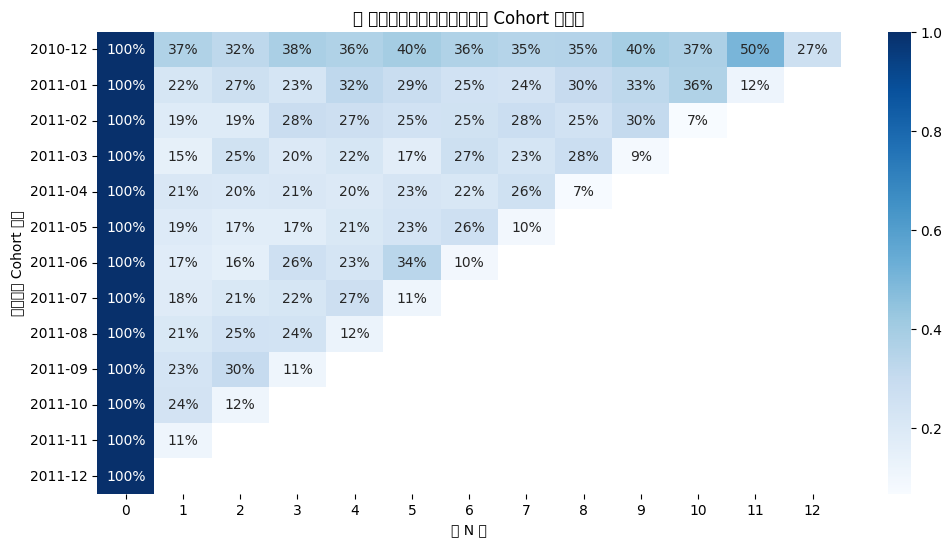

In [10]:
#热力图可视化：用seaborn 展示留存率表，图示用户粘性趋势
plt.figure(figsize=(12, 6))
sns.heatmap(retention, annot=True, fmt=".0%", cmap="Blues")
plt.title('📈 用户留存率热力图（按注册 Cohort 月份）')
plt.ylabel('首次购买 Cohort 月份')
plt.xlabel('第 N 月')
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22343 (\N{CJK UNIFIED IDEOGRAPH-5747}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30041 (\N{CJK UNIFIED IDEOGRAPH-7559}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23384 (\N{CJK UNIFIED IDEOGRAPH-5B58}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas

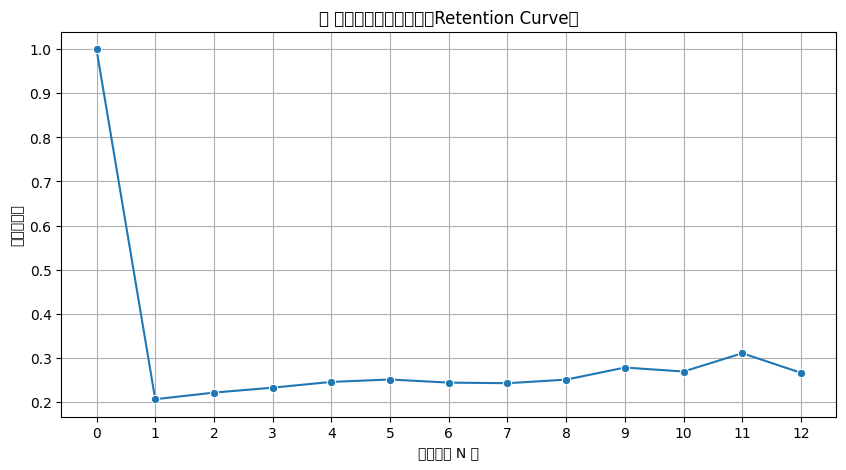

In [12]:
#留存曲线图：展示整体用户平均留存在时间上的衰减曲线
# 每列是某 Cohort 的第 N 月留存，计算平均
retention_mean_by_month = retention.mean().reset_index()
retention_mean_by_month.columns = ['CohortIndex', 'AvgRetention']

plt.figure(figsize=(10,5))
sns.lineplot(data=retention_mean_by_month, x='CohortIndex', y='AvgRetention', marker='o')
plt.title('📉 平均用户留存率曲线（Retention Curve）')
plt.xlabel('注册后第 N 月')
plt.ylabel('平均留存率')
plt.xticks(retention_mean_by_month['CohortIndex'])
plt.grid(True)
plt.show()
